# FastAI Import

Exec the cell below only if you don't have installed fastbook

In [ ]:
!pip install -Uqq fastbook

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.all import *

### Download the pet dataset

In [3]:
path = untar_data(URLs.PETS)
path

Path('/storage/data/oxford-iiit-pet')

### Split in cat and dogs

Cat's photos begin with uppercase.

Observe that the classes are imbalanced, we should balance them. We are not going to do it for simplicity

In [4]:
fns = (path/"images").ls()
cats = [fn for fn in fns if fn.name[0].isupper()]
dogs = [fn for fn in fns if not fn.name[0].isupper()]
len(cats),len(dogs)

(2403, 4990)

### Observe the data to be sure it's ok

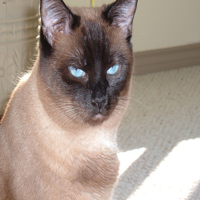

In [8]:
Image.open(cats[0]).resize((200,200))

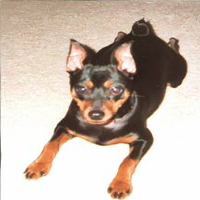

In [9]:
Image.open(dogs[0]).resize((200,200))

### Create DataBlock

We are using a DataBlock pretty similar to https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb

We changed get_y to classify between {'cat', 'dog'} classes.

We are not using batch_tfms to make all the resizing at item_tfms time. Remember that FastAI proposes a 'presizing' method (if you want to refresh that technique, it's explained in the cited notebook), it essentially consist on resize big images to square images for making a mini-batch and them perform additionally transformations (i.e. maybe additional resizing) to the mini-batch all together taking advantage of the GPU (and making other great tricks like composing transformations!).

We avoided batch_tfms to make dls.test_dl simpler. We want to show we can load and image, pre-process by hand and obtain the same result ad dls.test_dl
But you can use batch_tfms if you want. The idea always is that the input of the model here and in the native app are analogous so the validation result is extrapolated. If we resize with crop it will be ok. But for example a thing that might not be ok is trying to process vertically-flipped images in the device and not include that case when we train and validate. Read this fantastic article to understand (not only how and why create a good validation set) but also the underlying concept of what we wanna do (to extrapolate production environment): https://www.fast.ai/2017/11/13/validation-sets/


In [35]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(lambda x : 'cat' if x[0].isupper() else 'dog', 'name'),
                 item_tfms=Resize(224, ResizeMethod.Squish),
                 batch_tfms=[])
dls = pets.dataloaders(path/"images")

#### Train a simple model

We are going to use a pre-trained ResNet18. With just an epoch of fine tuning (training the head) will be enought.

In [36]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.181488,0.061704,0.020974,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.050373,0.048854,0.012179,00:23


Learner.predict method is usually the entry-door for predicting an image in production time (see https://github.com/fastai/fastbook/blob/master/02_production.ipynb)

It uses self.dls.test_dl to load and pre-process a sample, to make a singleton minibatch ready for self.get_preds.

In [8]:
Learner.predict??

Learner.get_preds calls (indirectly by self.\_do_epoch_validate) learn.model and learn.loss_func

In [24]:
Learner.get_preds??

Notice that also an 'activation layer' was applied (whitin the loss function).
 
Let's inspect to see that it is a CrossEntropyLoss (after flattening).

In [25]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

The activation layer is the one that take the last features and output probabilities.

As we conceptually think that the output of a model is a probability, in literature activation is usually part of 'the model'. 

But why don't we have it as a layer of learn.model?

CrossEntropyLoss is a combination of LogSoftmax (activation function or layer that will output a log of the probability) and NLLLoss (the proper loss function) in one single class. This is done because after a math simplification, the composition could be done faster than applying one after the other one.

So before saving the model we must add the activation (in this case I will add Softmax because I want the probabilities, not the log).

(I had some errors if I don't do the trace on cpu so I converted both model and random sample to cpu tensor)

In [29]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

final_model = nn.Sequential(learn.model,nn.Softmax()).to('cpu')

final_model.eval()
example = torch.rand(1, 3, 224, 224).cpu()
traced_script_module = torch.jit.trace(final_model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("./model_saved.ptl")

With that we are ready for executing the model on Android app. In the next section we will analyze that we know precisely which preprocessing is done, to replicate on the app

### Preprocessing analysis

We are not exporting the Learner object because it is a FastAI object and would be impossible to import natively in Android as it doesn't have java support. So we should have to mimic the pre-processing natively (i.e. in Android). And for that we have to understand what's happening under preprocessing's hood.
 
Note: FastAI is a fantastic library but sometimes it makes it so easy to do the things error-free for beginners that hides some behaviour. That happened to me when I was writing this tuto and found that cnn_learner modifies DataLoaders preprocessing! See https://forums.fast.ai/t/obscure-behaviour-learner-modifies-dataloaders/90138/2
Lucky is well documented (and also the code is very easy to inspect!)

We can see the transforms that we are apply by calling dls.after_item dls.before_batch and dls.after_batch:

In [38]:
dls.after_item

Pipeline: Resize -- {'size': (224, 224), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [39]:
dls.before_batch

Pipeline: 

In [40]:
dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

We will try to load a sample using test_dl call and by hand mimic the transforms Pipeline: loading the image and applying by hand the image transformation, normalization and channel permutation. 

Then we will compare it to be sure the result is the same, so we can be sure we can mimic preprocessing with simple image processing functions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


<AxesSubplot:>

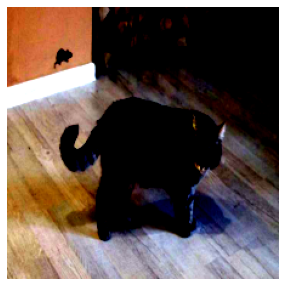

In [41]:
t1 = dls.test_dl(['./image-examples/cat1.jpg']).one_batch()[0].squeeze(0).cpu()
print(t1.shape)
show_image(t1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


<AxesSubplot:>

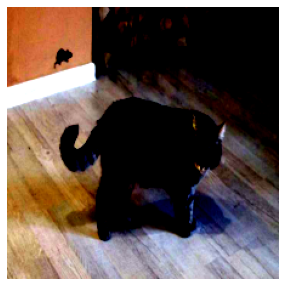

In [42]:
t2 = dls.test_dl([tensor(Image.open('./image-examples/cat1.jpg'))]).one_batch()[0].squeeze(0).cpu()
print(t2.shape)
show_image(t2)

In [43]:
torch.allclose(t1,t2,atol=1e-5)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


<AxesSubplot:>

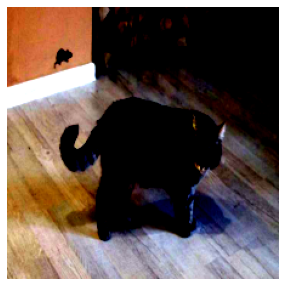

In [44]:
import torchvision
normalize = torchvision.transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

t3=tensor( Resize(224, ResizeMethod.Squish)(Image.open('./image-examples/cat1.jpg').convert("RGB")) ).float().permute(2,0,1)/255
t3=normalize(t3)
print(t3.shape)
show_image(t3)

In [45]:
torch.allclose(t1,t3,atol=1e-5)

True

Fantastic! So the only thing we need to do is:
- Loading the image
- Resize with the same method it uses ResizeMethod.Squish
- Scale from [0 , 255] to [0, 1] range (divide by 255)
- Apply imagenet_stats normalization (this is added by default by cnn_learner if we miss it in DataLoaders and using pre-trained model)